# **Taller de Aprendizaje Automático en Python - Día 4**

## **Autores:**



*   José Clemente Hernández Hernández
*   Gustavo Adolfo Vargas Hákim

{{ badge }}

# **Redes Neuronales Convolucionales**

Utilizaremos la librería PyTorch para programar nuestras Redes Neuronales Convolucionales (CNN). PyTorch nos ofrece varias características muy atractivas:

*   Paquetería para Deep Learning
*   Diferenciador Automático
*   Interfaz con CUDA para utilizar GPUs



In [1]:
!pip3 install torch torchvision torchaudio

     |████████████████████████████████| 1.9MB 7.6MB/s 


**Importando Librerías**

In [25]:
import torch
from torchvision import datasets, utils
from torch import optim
from torchsummary import summary
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

**Utilizando la GPU**

PyTorch nos ofrece la posibilidad de entrenar nuestros modelos en una o más GPUs. Google Colab, por otro, lado, nos ofrece el ecceso gratuito a una GPU. Para activarla, seleccionar: Editar -> Configuración del Notebook y elegir la opción GPU para luego guardar. Corramos de nuevo todas las celdas que tenemos hasta el momento.

Ahora revisamos que efectivamente PyTorch detecte la GPU.

In [3]:
'''Revisando acceso a GPU'''
if torch.cuda.is_available():
  device = torch.device("cuda:0")

print(device)

cuda:0


**Cargando Datasets**

PyTorch tiene algunos datasets precargados a los que podemos acceder. En este ejemplo, trabajaremos con MNIST, la popular colección de imágenes de caracteres numéricos escritos a mano.

In [4]:
'''Descargando la base de datos MNIST'''
#Primero definimos a la raíz como carpeta para la descarga
path = './data'

#Descargamos los datos de entrenamiento
train_data = datasets.MNIST(path, train = True, download = True)

#Descargamos los datos de prueba
val_data = datasets.MNIST(path, train = False, download = True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Ahora separamos las imágenes de las etiquetas. En este caso, queremos clasificar el dígito correspondiente a cada imagen.

In [72]:
'''Separar imágenes y etiquetas'''
X_train, y_train = train_data.data, train_data.targets #En datos de entrenamiento
X_test, y_test = val_data.data, val_data.targets #En datos de prueba

Analicemos ahora cómo son nuestros datos. Recordemos que en el mundo del **Deep Learning**, solemos trabajar con tensores, es decir, arreglos de mayor dimensionalidad. 

In [73]:
'''Analizando la forma de los datos'''
print('El tamaño del conjunto de entrenamiento es: ', X_train.shape)
print('El tamaño del conjunto de prueba es: ', X_test.shape)

El tamaño del conjunto de entrenamiento es:  torch.Size([60000, 28, 28])
El tamaño del conjunto de prueba es:  torch.Size([10000, 28, 28])


Los resultados anteriores significan lo siguiente: 

*   El conjunto de entrenamiento tiene 60000 imágenes de $28 \times 28$.
*   El conjunto de prueba tiene 10000 imágenes de $28 \times 28$.

Podemos ver también qué forma tienen las etiquetas.


In [74]:
'''Analizando la forma de las etiquetas'''
print('El tamaño de las etiquetas de entrenamiento es: ', y_train.shape)
print('El tamaño de las etiquetas de prueba es: ', y_test.shape)

El tamaño de las etiquetas de entrenamiento es:  torch.Size([60000])
El tamaño de las etiquetas de prueba es:  torch.Size([10000])


En este caso, las etiquetas de entrenamiento son tensor unidemensional de 60000 valores, mientras que las etiquetas de prueba son un tensor unidimensional de 10000 valores.

**Preprocesamiento**

Nuestras imágenes deberán pasar por un proceso que ajuste el formato actual de nuestros datos al formato que PyTorch necesita para operar.

En el estado actual, cada imágen está en blanco y negro, es decir, sólo hay un canal (profundidad igual a $1$). Por ello, los datos tienen la forma $(N, H, W)$, donde:

*  $N$: número de imágenes
*  $H$: altura de las imágenes (número de filas en la matriz)
*  $W$: ancho de las imágenes (número de columnas en la matriz)

Es como si todas las imágenes se apilaran para formar un gran *volumen*. 

En PyTorch, sin embargo, el número de canales debe estar explícitamente representado en el tamaño del tensor. Específicamente, la forma de este tensor debe tener el format $(N, C, H, W)$, donde $C$ es el número de canales. En nuestro ejemplo, $C = 1$. Si las imágenes fueran a color (formato RGB), el valor sería $C = 3$. 

PyTorch nos permite reconfigurar nuestros tensores para ajustarse a este nuevo formato.

In [75]:
'''Reconfigurando nuestros datos'''
if len(X_train.shape) == 3: #Si el tensor tiene 3 dimensiones (formato original)
  X_train = X_train.unsqueeze(1) #Este método separa el número de canales como una dimensión por separado
print('La nueva forma del tensor de entrenamiento es: ', X_train.shape)

if len(X_test.shape) == 3: #Si el tensor tiene 3 dimensiones (formato original)
  print('ok')
  X_test = X_test.unsqueeze(1) #Este método separa el número de canales como una dimensión por separado
print('La nueva forma del tensor de prueba es: ', X_test.shape)

La nueva forma del tensor de entrenamiento es:  torch.Size([60000, 1, 28, 28])
ok
La nueva forma del tensor de prueba es:  torch.Size([10000, 1, 28, 28])


Con nuestros datos ya en el órden espacial que necesitamos, podemos visualizarlos. Crearemos una función que muestre algunos ejemplos de los datos que tenemos.

In [9]:
'''Función de visualización de imágenes'''
def show(img):
  #Convertimos el tensor a un arreglo de numpy
  npimg = img.numpy()

  #Convertimos las imágenes al formato (H, W, C)
  npimg_tr = np.transpose(npimg, (1,2,0))
  plt.imshow(npimg_tr, interpolation = 'nearest')

torch.Size([3, 152, 242])


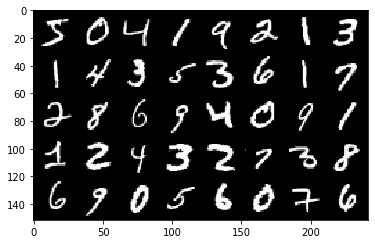

In [10]:
#Creaos la matriz de de 40 imágenes, 8 por fila
x_grid = utils.make_grid(X_train[:40], nrow = 8, padding = 2) #Creamos la matriz de imágenes
print(x_grid.shape)

#Llamamos nuestra función para simplemente mostrar el resultado
show(x_grid)

**Preparando nuestros datos para entrenar**

En PyTorch, hay dos objetos importantes, ```dataset``` y ```dataloader```. Estos objetos funcionan como organizadores e **iteradores** para nuestros datos. Al momento de pasar los datos por la CNN, el ```dataloader``` se encargar de iterar sobre ellos para evitar que todos esten abiertos al mismo tiempo. 



In [76]:
'''Convertimos los tensores en objetos dataset'''
train_ds = torch.utils.data.TensorDataset(X_train, y_train)
test_ds = torch.utils.data.TensorDataset(X_test, y_test)

#Observemos como se iteran los datasets
for x, y in test_ds:
  print(x.shape, y.item())
  break

torch.Size([1, 28, 28]) 7


Ahora, convertiremos nuestros objetos ```dataset``` en objetos ```dataloader```. Es importante notar que el ```dataloader``` nos pide un tamaño de **batch**. Recordemos que en lugar de pasar imagen por imagen a nuestra red, pasaremos grupos de imágenes llamados batches. La función de error se calcular para todo el batch y se promedio en función de su tamaño. 

In [77]:
'''Convertimos datasets en dataloaders'''
train_dl = DataLoader(train_ds, batch_size = 8) #Hay que definir un tamaño de batch
test_dl = DataLoader(test_ds, batch_size = 8) #Hay que definir un tamaño de batch

#Observemos como se iteran los dataloaders
for xb, yb in test_dl:
  print(xb.shape)
  print(yb.shape)
  break

torch.Size([8, 1, 28, 28])
torch.Size([8])


**Creando nuestra Red Neuronal Convolucional**

PyTorch tiene la característica de tener una funcionamiento muy similar a Python puro. En este sentido, la creación de una red neuronal implica crear una clase. Estas clases heredan propiedades de la clase ```nn.Module```. La clase debe tener dos partes esenciales: 

*   ```__init__```: en donde se definen las partes que componen a nuestra CNN. 
*   ```forward```: el método que define el comportamiento de la CNN, utilizando los componentes disponibles en ```__init__```.

In [93]:
'''Creado una CNN'''
class Net(nn.Module):
  #Método _init_ para inicializar la red
  def __init__(self):
    super(Net, self).__init__()
    #A continuación podemos definir los elementos que tenrá nuestra red
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 20, kernel_size = 5, stride = 1)
    self.relu1 = nn.ReLU(inplace = True)
    self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.conv2 = nn.Conv2d(in_channels = 20, out_channels = 50, kernel_size = 5, stride = 1)
    self.relu2 = nn.ReLU(inplace = True)
    self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.fc1 = nn.Linear(in_features = 4*4*50, out_features = 500)
    self.relu3 = nn.ReLU(inplace = True)
    self.fc2 = nn.Linear(in_features = 500, out_features = 10)
    self.relu4 = nn.ReLU(inplace = True)

  #Método forward para definir el paso hacia adelante
  def forward(self, x): #La variable x representa a la entrada de la red (un batch)
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.pool2(x)
    x = torch.flatten(x, 1) #Convertimos el último mapa de activación en un vector
    x = self.fc1(x)
    x = self.relu3(x)
    x = self.fc2(x)
    x = self.relu4(x)
    x = F.log_softmax(x, dim = 1) #Función de activación softmax que utilizaremos para clasificación multi-clase

    return x

Analicemos los elementos que utilizamos:

*  ```Conv2d```: se usa para las capas de convolución. Los parámetros que usamos son (número de canales de entrada, número de filtros, tamaño de los kernels que cada filtro, stride) en el órden de lo que aparece en el código.
*  ```MaxPool2d```: se usa para el Max Pooling. Los parámetros que usamos son (tamaño del kernel, stride).
*  ```Linear```: se usa para las capas de neuronas (fully-connected). Los parámetros que usamos son (número de valores de entrada, número de neuronas en la capa). Es importante notar que la primera capa fully-connected tiene tantos datos de entrada como sea el número de "píxeles" en el último mapa de activación. 

In [94]:
'''Creamos una red a partir de nuestra clase'''
model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (relu3): ReLU(inplace=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (relu4): ReLU(inplace=True)
)


Para poder aprovechar la GPU, tenemos que enviar nuestra CNN a la GPU. En estos momentos, todo lo que hemos hecho se encuentra en la CPU de la máquina virtual de Google Colab.

In [95]:
'''Moviendo la CNN a la GPU'''
model.to(device)

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (relu3): ReLU(inplace=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (relu4): ReLU(inplace=True)
)

Una vez en la GPU, podemos usar la herramienta ```summary``` para desplegar información valiosa sobre nuestra red, como los tamaños de salida de cada capa, y el número de parámetros totales de nuestra red.

In [96]:
summary(model, input_size = (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
              ReLU-2           [-1, 20, 24, 24]               0
         MaxPool2d-3           [-1, 20, 12, 12]               0
            Conv2d-4             [-1, 50, 8, 8]          25,050
              ReLU-5             [-1, 50, 8, 8]               0
         MaxPool2d-6             [-1, 50, 4, 4]               0
            Linear-7                  [-1, 500]         400,500
              ReLU-8                  [-1, 500]               0
            Linear-9                   [-1, 10]           5,010
             ReLU-10                   [-1, 10]               0
Total params: 431,080
Trainable params: 431,080
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.26
Params size (MB): 1.64
Estimated T

**Entrenamiento**

Ya que la CNN está lista, podemos comenzar a definir las características de nuestro entrenamiento.

In [99]:
'''Definiendo parámetros de entrenamiento'''
#Función de pérdida (lo que queremos minimizar)
loss_func = nn.NLLLoss(reduction = "sum")

#Optimizador (cómo vamos a minimizar)
opt = optim.Adam(model.parameters(), lr = 1e-4) #Aquí definimos el coeficiente de aprendizaje (learning rate)

#Número de épocas
num_epochs = 10

Con estos hiperparámetros ya definidos,podemos escribir nuestro **loop** de entrenamiento.

In [100]:
'''Entrenamiento de nuestra CNN'''
#Loop principal
for epoch in range(num_epochs):
  '''Entrenamiento'''
  #Ponemos a nuestro modelo en modo entrenamiento
  model.train()

  #Inicializamos función de pérdida y accuracy de entrenamiento
  loss_t = 0.0
  acc_t = 0.0

  #Obtenemos el número de datos de entrenamiento
  len_data = len(train_dl.dataset)

  #Iteramos sobre los batches de entrenamiento (train_dl)
  for xb, yb in train_dl:
    #Movemos el batch y las etiquetas a la GPU
    xb = xb.type(torch.float).to(device)
    yb = yb.to(device)

    #Obtenemos la predicción de la red
    yb_h = model(xb)

    #Calculamos valor de la función de pérdida
    loss_b = loss_func(yb_h, yb)

    #Optimizamos (paso hacia atrás)
    loss_b.backward()
    opt.step()
    opt.zero_grad()

    #Obtenemos el accuracy de este batch
    pred = yb_h.argmax(dim = 1, keepdim = True) #Obtebemos las probabilidades máximas de cada batch
    acc_b = pred.eq(yb.view_as(pred)).sum().item() #Comparamos las predicciones con las etiquetas

    #Actualizamos la pérdida y accuracy totales de entrenamiento
    loss_t += loss_b.item()
    if acc_b is not None:
        acc_t += acc_b
  
  #Promediamos la pérdida y accuracy de entrenamiento
  loss_t /= len_data
  acc_t /= len_data

  '''Validación'''
  #Inicializamos función de pérdida y accuracy de prueba
  loss_v = 0.0
  acc_v = 0.0

  #Obtenemos el número de datos de prueba
  len_data = len(test_dl.dataset)

  #Ponemos a nuestro modelo en modo evaluación
  model.eval()

  #Especificamos que para utilizar los datos de prueba, PyTorch no calcule ningún gradiente
  with torch.no_grad(): 
    #Iteramos sobre los batches de prueba (test_dl)
    for xb, yb in test_dl:
      #Movemos el batch y las etiquetas a la GPU
      xb = xb.type(torch.float).to(device)
      yb = yb.to(device)

      #Obtenemos la predicción de la red
      yb_h = model(xb)

      #Calculamos valor de la función de pérdida
      loss_b = loss_func(yb_h, yb)

      #Obtenemos el accuracy de este batch
      pred = yb_h.argmax(dim = 1, keepdim = True) #Obtebemos las probabilidades máximas de cada batch
      acc_b = pred.eq(yb.view_as(pred)).sum().item() #Comparamos las predicciones con las etiquetas

      #Actualizamos la pérdida y accuracy totales de prueba
      loss_v += loss_b.item()
      if acc_b is not None:
        acc_v += acc_b

    #Promediamos la pérdida y accuracy de entrenamiento
    loss_v /= len_data
    acc_v /= len_data

    print('Época: %d, Pérdida de entrenamiento: %.5f, Pérdidad de prueba: %.5f, Accuracy de entrenamiento: %.4f, Accuracy de prueba: %.4f'
          %(epoch, loss_t, loss_v, acc_t, acc_v))

Época: 0, Pérdida de entrenamiento: 0.24005, Pérdidad de prueba: 0.26935, Accuracy de entrenamiento: 0.8979, Accuracy de prueba: 0.8940
Época: 1, Pérdida de entrenamiento: 0.23947, Pérdidad de prueba: 0.27340, Accuracy de entrenamiento: 0.8981, Accuracy de prueba: 0.8951
Época: 2, Pérdida de entrenamiento: 0.23681, Pérdidad de prueba: 0.26711, Accuracy de entrenamiento: 0.8985, Accuracy de prueba: 0.8952
Época: 3, Pérdida de entrenamiento: 0.23736, Pérdidad de prueba: 0.27284, Accuracy de entrenamiento: 0.8987, Accuracy de prueba: 0.8944
Época: 4, Pérdida de entrenamiento: 0.23514, Pérdidad de prueba: 0.26773, Accuracy de entrenamiento: 0.8992, Accuracy de prueba: 0.8967
Época: 5, Pérdida de entrenamiento: 0.23457, Pérdidad de prueba: 0.27116, Accuracy de entrenamiento: 0.8993, Accuracy de prueba: 0.8958
Época: 6, Pérdida de entrenamiento: 0.23425, Pérdidad de prueba: 0.27286, Accuracy de entrenamiento: 0.8996, Accuracy de prueba: 0.8958
Época: 7, Pérdida de entrenamiento: 0.23408, Pér